In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/landslide/TrainData'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
file_path = 'C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData'

if os.path.exists(file_path):
    print("✅ File found!")
else:
    print("❌ File NOT found! Check the path.")


✅ File found!


In [5]:
import os
print("Files in directory:", os.listdir(file_path))


Files in directory: ['img', 'mask']


In [6]:
import h5py

if os.path.exists(file_path):
    with h5py.File('C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\img\\image_1.h5', "r") as h5f:
        print("✅ H5 file opened successfully!")
        print("Keys in H5 file:", list(h5f.keys()))
else:
    print("❌ File still not found. Check your path and Google Drive.")


✅ H5 file opened successfully!
Keys in H5 file: ['img']


In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, UpSampling2D, 
                                     AveragePooling2D, Conv2DTranspose, Concatenate, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

In [8]:
with h5py.File('C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\img\\image_1.h5', 'r') as hf:
    print(hf.keys())

<KeysViewHDF5 ['img']>


In [9]:
with h5py.File('C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\mask\\mask_10.h5', 'r') as hf1:
    print(hf1.keys())

<KeysViewHDF5 ['mask']>


Available keys in the HDF5 file: ['img']
Input data shape: (128, 128, 14)


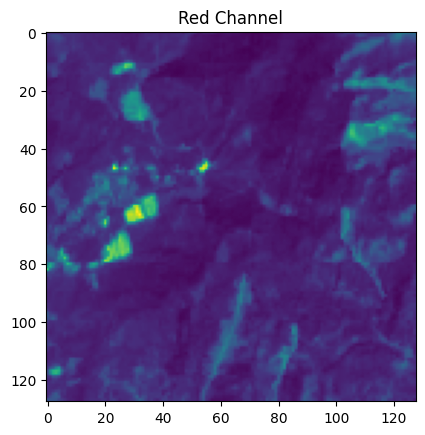

data_ndvi shape: (128, 128) f_data shape: (1, 128, 128, 3)


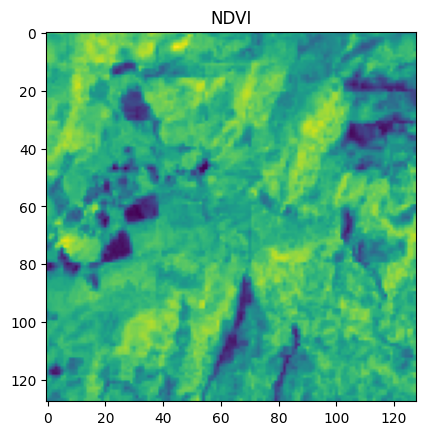

In [10]:
path_single = r'C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\img\\image_1.h5'
path_single_mask = r'C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\mask\\mask_10.h5'

f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file
with h5py.File(path_single, 'r') as hdf:
    # Print keys in the HDF5 file
    ls = list(hdf.keys())
    print("Available keys in the HDF5 file:", ls)
    
    # Check if 'img' key exists
    if 'img' not in ls:
        raise KeyError("'img' key not found in HDF5 file")
    
    # Load the image data
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)
    
    # Check the shape to avoid indexing errors
    if data.shape[2] < 14:
      raise ValueError("The data has fewer than 14 channels. Shape:", data.shape)

    # Display a sample image (e.g., Red channel)
    plt.imshow(data[:, :, 3])  # Red channel (adjust as needed)
    plt.title("Red Channel")
    plt.show()

    # Extract specific bands for NDVI calculation
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]

    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red), where=(data_nir + data_red) != 0)
    
    # Store NDVI and other bands in f_data
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("data_ndvi shape:", data_ndvi.shape, "f_data shape:", f_data.shape)
    
    # Plot NDVI
    plt.imshow(data_ndvi, cmap='viridis')
    plt.title("NDVI")
    plt.show()

In [11]:
class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, img_size=(128, 128), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        # List all the image and mask file names
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.image_files) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        if self.shuffle:
            temp = list(zip(self.image_files, self.mask_files))
            np.random.shuffle(temp)
            self.image_files, self.mask_files = zip(*temp)

    def __getitem__(self, index):
        # Get the list of image and mask files for this batch
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        # Load and preprocess the images and masks
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = self.load_image(os.path.join(self.image_dir, img_file))
            mask = self.load_mask(os.path.join(self.mask_dir, mask_file))
            images.append(img)
            masks.append(mask)
        # Return as numpy arrays
        return np.array(images), np.array(masks)

    def load_image(self, img_path):
        with h5py.File(img_path, 'r') as hdf:
            img_data = np.array(hdf.get('img'))  # (128, 128, 14)
            img_data = img_data / 255.0  # Normalize to [0, 1]
            return img_data

    def load_mask(self, mask_path):
        with h5py.File(mask_path, 'r') as hdf:
            mask_data = np.array(hdf.get('mask'))  # (128, 128)
            mask_data = np.expand_dims(mask_data, axis=-1)  # (128, 128, 1)
            return mask_data

In [12]:
""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)
    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [13]:
def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [14]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(y_true, dtype='float32')  # Ensure both are float32
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true_f)  # Flatten after conversion

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
train_generator = DataGenerator(
    image_dir='C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\img',
    mask_dir='C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\mask',
    batch_size=32,  # Adjust based on memory
    img_size=(128, 128),  # Match your input data
    shuffle=True
)

In [16]:
strategy = tf.distribute.MirroredStrategy()
input_shape = (128, 128, 14)
with strategy.scope():
    model = DeepLabV3Plus(input_shape)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=dice_loss, 
                  metrics=['accuracy'])
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │     43,968 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 17,864,705 (68.15 MB)

 Trainable params: 17,829,921 (68.02 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [17]:
history = model.fit(train_generator, epochs=10)

c:\Users\sanjeev\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 970s 8s/step - accuracy: 0.8487 - loss: 0.8282
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 954s 8s/step - accuracy: 0.9768 - loss: 0.5131
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 949s 8s/step - accuracy: 0.9830 - loss: 0.3973
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1143s 10s/step - accuracy: 0.9845 - loss: 0.3794
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1169s 10s/step - accuracy: 0.9845 - loss: 0.3500
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 787s 7s/step - accuracy: 0.9851 - loss: 0.3485
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 853s 7s/step - accuracy: 0.9855 - loss: 0.3355
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 801s 7s/step - accuracy: 0.9858 - loss: 0.3149
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 810s 7s/step - accuracy: 0.9862 - loss: 0.3111
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 835s 7s/step - accuracy: 0.9856 - loss: 0.3130


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │     43,968 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 17,864,705 (68.15 MB)

 Trainable params: 17,829,921 (68.02 MB)

 Non-trainable params: 34,784 (135.88 KB)

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 1094s 9s/step - accuracy: 0.6912 - dice_coefficient: 0.0790 - loss: 0.9210 - val_accuracy: 0.9768 - val_dice_coefficient: 0.0436 - val_loss: 0.9564 - learning_rate: 1.0000e-05
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 1212s 10s/step - accuracy: 0.8998 - dice_coefficient: 0.1777 - loss: 0.8223 - val_accuracy: 0.9767 - val_dice_coefficient: 0.0377 - val_loss: 0.9623 - learning_rate: 1.0000e-05
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 1242s 11s/step - accuracy: 0.9513 - dice_coefficient: 0.2896 - loss: 0.7104 - val_accuracy: 0.9768 - val_dice_coefficient: 0.0200 - val_loss: 0.9800 - learning_rate: 1.0000e-05
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9685 - dice_coefficient: 0.3580 - loss: 0.6420
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
118/118 ━━━━━━━━━━━━━━━━━━━━ 973s 8s/step - accuracy: 0.9685 - dice_coefficient: 0.3582 - loss: 0.6418 - val_accuracy: 0.9769 - val_dice_coefficient: 0.0190 - val_los

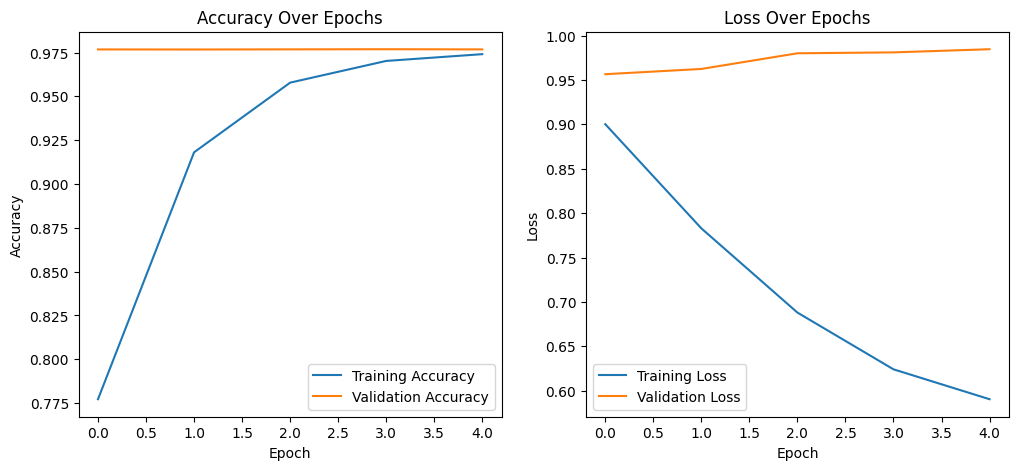

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Updated Data Generator
train_generator = DataGenerator(
    image_dir='C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\img',
    mask_dir='C:\\Users\\sanjeev\\OneDrive\\Desktop\\UP HACK\\archive (5)\\TrainData\\mask',
    batch_size=32,
    img_size=(128, 128),
    shuffle=True
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Define Strategy
strategy = tf.distribute.MirroredStrategy()
input_shape = (128, 128, 14)

with strategy.scope():
    model = DeepLabV3Plus(input_shape)
    model.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss=dice_loss, 
                  metrics=['accuracy', dice_coefficient])
    model.summary()

# Train with augmented data
history = model.fit(
    train_generator,
    epochs=5,  # Increased to allow for early stopping
    validation_data=train_generator,  # Use separate validation data if possible
    callbacks=[early_stopping, lr_scheduler]
)

# Plotting Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import pickle

# Suppose your model variable is called clf (change if you used another name)
with open("res.pkl", "wb") as f:
    pickle.dump('Trained Model.ipynb', f)